In [ ]:
!pip install roifile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python3 --version

Python 3.7.11


In [ ]:
from skimage import io
import os 
from roifile import ImagejRoi
import tifffile
import matplotlib.pyplot as plt
import cv2
import numpy as np

#Produce Masks from ROI file

In [ ]:
src="/content/drive/MyDrive/Colab Notebooks/spermdata/spermdata/ROI/C2-Image 39_RoiSet"

In [ ]:
os.chdir(src)

In [ ]:
list_coordinates = []
for root, dirs, files in os.walk(src):
  for file in files:
    roi = ImagejRoi.fromfile(file)
    list_x=roi.coordinates()[:,0]
    list_y=roi.coordinates()[:,1]
    list_xy=[]
    for i in range(0,len (list_x)-1):
      coordinate=[list_x[i],list_y[i]]
      list_xy.append(coordinate)
    list_coordinates.append(list_xy)
print(list_coordinates)

[[[403.0, 191.0], [402.3444, 191.55669], [401.59482, 192.0102], [400.757, 192.35707], [399.8373, 192.59468], [398.84277, 192.72122], [397.7809, 192.73573], [396.65985, 192.63809], [395.48813, 192.42903], [394.2746, 192.11018], [393.02856, 191.68393], [391.75946, 191.15353], [390.47696, 190.52304], [389.19086, 189.79723], [387.9109, 188.98164], [386.64682, 188.08247], [385.4083, 187.10657], [384.20468, 186.06136], [383.0452, 184.9548], [381.93863, 183.79532], [380.89343, 182.59172], [379.91754, 181.35318], [379.01837, 180.08911], [378.20276, 178.80916], [377.47696, 177.52304], [376.84647, 176.24055], [376.31607, 174.97145], [375.88983, 173.7254], [375.57095, 172.51189], [375.3619, 171.34013], [375.26428, 170.21907], [375.27878, 169.15723], [375.4053, 168.16267], [375.6429, 167.243], [375.9898, 166.40518], [376.44333, 165.65562], [377.0, 165.0], [377.6556, 164.44331], [378.40518, 163.9898], [379.243, 163.64293], [380.1627, 163.40532], [381.15723, 163.27878], [382.2191, 163.26427], [383.3

In [ ]:
im = np.zeros([512,512])
for coordinates in list_coordinates:
  
  cv2.fillConvexPoly(im, np.array(coordinates, 'int32'), 255)

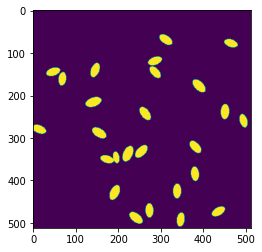

In [ ]:
plt.imshow(im)
plt.show()

(array([248521.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

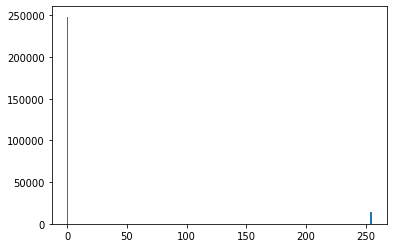

In [ ]:
plt.hist(im.ravel(), 256, [0, 255])

In [ ]:
src="/content/drive/MyDrive/Colab Notebooks/spermdata/spermdata/ROI/labels"
os.chdir(src)

In [ ]:
cv2.imwrite('Image 39.png', im)

True

# Test the groundtruth

In [ ]:
import os
src="/content/drive/MyDrive/Colab Notebooks/spermdata/spermdata/ROI/labels"
os.chdir(src)

In [ ]:
im=cv2.imread('Image39.png')
plt.hist(im.ravel(), 256, [0, 255])

#Dataset

In [ ]:
import os
src="/content/drive/MyDrive/Colab Notebooks/spermdata/spermdata/"
os.chdir(src)

In [ ]:
from torch.utils.data import Dataset
import os
import cv2
import numpy as np
import random
class SegDataset(Dataset):
  def __init__(self, traintxt, imagesize, cropsize,transform=None):
    self.images = []
    self.labels = []

    lines = open(traintxt,'r').readlines()
    for line in lines:
      imagepath,labelpath = line.strip().split(' ')
      self.images.append(imagepath)
      self.labels.append(labelpath)

      self.imagesize = imagesize
      self.cropsize = cropsize

      assert len(self.images) == len(self.labels)
      self.transform  = transform
      self.samples = []
      for i in range(len(self.images)):
          self.samples.append((self.images[i],self.labels[i]))

  def __getitem__(self, item):
    img_path, label_path = self.samples[item]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (self.imagesize,self.imagesize),interpolation=cv2.INTER_NEAREST)
    label = cv2.imread(label_path,0)/255
    label = cv2.resize(label, (self.imagesize, self.imagesize), interpolation=cv2.INTER_NEAREST)
      ## 随机裁剪数据增强，可添加更多操作
    #randoffsetx = np.random.randint(self.imagesize - self.cropsize)
    #randoffsety = np.random.randint(self.imagesize - self.cropsize)
    #img = img[randoffsety:randoffsety + self.cropsize, randoffsetx:randoffsetx + self.cropsize]
    #label = label[randoffsety:randoffsety + self.cropsize, randoffsetx:randoffsetx + self.cropsize]

    if self.transform is not None:
      img = self.transform(img)
    return img, label

  def __len__(self):
    return len(self.images)

#Model

In [ ]:
import torch
from torch import nn
class simpleNet5(nn.Module):
  def __init__(self):
    super(simpleNet5, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(True),)
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )
    self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
    self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
    self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )
    self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, 2, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
    self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
    self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
    self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
    self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(32, 8, 3, 2, 1, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(True)
        )
    self.classifier = nn.Conv2d(8, 1, kernel_size=1)

  def forward(self, x):       
    out1 = self.conv1(x)     
    out2 = self.conv2(out1)     
    out3 = self.conv3(out2)   
    out4 = self.conv4(out3)
    out5 = self.conv5(out4)
    out6 = self.deconv1(out5) +out4
    out7 = self.deconv2(out6)+out3
    out8 = self.deconv3(out7)+out2
    out9 = self.deconv4(out8)+out1
    out = self.deconv5(out9)
    out = self.classifier(out)
    out = torch.sigmoid(out)
    return out


In [ ]:
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
class Recurrent_block(nn.Module):
    def __init__(self, ch_out, t=2):
        super(Recurrent_block, self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):

            if i == 0:
                x1 = self.conv(x)

            x1 = self.conv(x + x1)
        return x1

class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1
class R2U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=1, t=2):
        super(R2U_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch, ch_out=64, t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64, ch_out=128, t=t)

        self.RRCNN3 = RRCNN_block(ch_in=128, ch_out=256, t=t)

        self.RRCNN4 = RRCNN_block(ch_in=256, ch_out=512, t=t)

        self.RRCNN5 = RRCNN_block(ch_in=512, ch_out=1024, t=t)

        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512, t=t)

        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256, t=t)

        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128, t=t)

        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64, t=t)

        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)
        d1 = self.sigmoid(d1)
        return d132w


#Train

In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 124 kB 7.4 MB/s 


In [ ]:
src="/content/drive/MyDrive/Colab Notebooks/spermdata/spermdata/"
os.chdir(src)

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
import numpy as np

writer = SummaryWriter() #可视化

batchsize = 8
epochs = 200
imagesize = 512 #缩放图片大小
cropsize = 64 #训练图片大小
train_data_path = './train.txt'
val_data_path = './valid.txt'

# 数据预处理
data_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])


# 图像分割数据集
train_dataset = SegDataset(train_data_path,imagesize,cropsize,data_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
val_dataset = SegDataset(val_data_path,imagesize,cropsize,data_transform)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.__len__(), shuffle=True)

image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = val_dataset
dataloaders = {}
dataloaders['train'] = train_dataloader
dataloaders['val'] = val_dataloader

device = torch.device('cpu')
net = simpleNet5().to(device)
#net = U_Net().to(device)

criterion = nn.BCELoss() #使用softmax loss损失，输入label是图片
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1) #每50个epoch，学习率衰减

if not os.path.exists('checkpoints'):
  os.mkdir('checkpoints')

for epoch in range(1, epochs+1):
  print('Epoch {}/{}'.format(epoch, epochs - 1))
  for phase in ['train', 'val']:
    if phase == 'train':
      scheduler.step()
      net.train(True)  # Set model to training mode
    else:
      net.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_accs = 0.0

    n = 0
    for data in dataloaders[phase]:
      imgs, labels = data
      img, label = imgs.to(device).float(), labels.to(device).float()
      output = net(img)
      output= torch.squeeze(output)
      loss = criterion(output, label) 
      output_mask = output.data.numpy().copy()
      y_mask = label.data.numpy().copy()
      output_mask=(output_mask>0.5)
      output=(output>0.5)
      inter = torch.dot(output.view(-1).float(),label.view(-1))
      union = torch.sum(output.view(-1).float()) + torch.sum(label.view(-1)) - inter + 0.0001
        # Calculate DICE 
      acc= inter / union
      
      #acc = (output_mask == y_mask)

      optimizer.zero_grad()
      if phase == 'train':
            # 梯度置0，反向传播，参数更新
        loss.backward()
        optimizer.step()

      running_loss += loss.data.item()
      running_accs += acc
      n += 1

    epoch_loss = running_loss / n
    epoch_acc = running_accs / n

    if phase == 'train':
      writer.add_scalar('data/trainloss', epoch_loss, epoch)
      writer.add_scalar('data/trainacc', epoch_acc, epoch)
      print('train epoch_{} loss='+str(epoch_loss).format(epoch))
      print('train epoch_{} dice='+str(epoch_acc).format(epoch))
    else:
      writer.add_scalar('data/valloss', epoch_loss, epoch)
      writer.add_scalar('data/valacc', epoch_acc, epoch)
      print('val epoch_{} loss='+str(epoch_loss).format(epoch))
      print('val epoch_{} dice='+str(epoch_acc).format(epoch))


if epoch % 10 == 0:

  torch.save(net, 'checkpoints/model_epoch_{}.pth'.format(epoch))
  print('checkpoints/model_epoch_{}.pth saved!'.format(epoch))

writer.export_scalars_to_json("./all_scalars.json")
writer.close()

Epoch 1/199


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train epoch_{} loss=0.49076901078224183
train epoch_{} dice=tensor(0.0008)
val epoch_{} loss=0.47023892402648926
val epoch_{} dice=tensor(0.)
Epoch 2/199
train epoch_{} loss=0.2984369397163391
train epoch_{} dice=tensor(0.)
val epoch_{} loss=0.26929762959480286
val epoch_{} dice=tensor(0.)
Epoch 3/199
train epoch_{} loss=0.2433178186416626
train epoch_{} dice=tensor(0.)
val epoch_{} loss=0.19708840548992157
val epoch_{} dice=tensor(0.)
Epoch 4/199
train epoch_{} loss=0.25559017062187195
train epoch_{} dice=tensor(0.)
val epoch_{} loss=0.18808358907699585
val epoch_{} dice=tensor(0.)
Epoch 5/199
train epoch_{} loss=0.25409910678863523
train epoch_{} dice=tensor(0.)
val epoch_{} loss=0.18915559351444244
val epoch_{} dice=tensor(0.)
Epoch 6/199
train epoch_{} loss=0.23810153007507323
train epoch_{} dice=tensor(0.)
val epoch_{} loss=0.18828651309013367
val epoch_{} dice=tensor(0.)
Epoch 7/199
train epoch_{} loss=0.2264874279499054
train epoch_{} dice=tensor(0.)
val epoch_{} loss=0.18552246

#Inference

In [ ]:
import os
src="/content/drive/MyDrive/Colab Notebooks/spermdata/spermdata/"
os.chdir(src)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import cv2
import sys
import torch.nn.functional as F
import numpy as np

data_transforms =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

modelpath ="./checkpoints/model_epoch_200.pth"
net = torch.load(modelpath,map_location='cpu')
net.eval()

imagepaths = "./test"
torch.no_grad()

image = cv2.imread("./test/C2-Image2.tif")


In [ ]:
imgblob = data_transforms(image).unsqueeze(0)
predict = net(imgblob).cpu().data.numpy().copy()
predict = predict>0.5
result = np.squeeze(predict)

print(np.max(result))
result = (result*255).astype(np.uint8)
print(result)
resultimage = image.copy()
cv2.imwrite("./test/C2-Image2_result.tif",result)

True
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


True